Following is research data for investigating the disease situation in a given area. This research recruits volunteers who must be at least 40 years old.


In [144]:
#%pip install matplotlib

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt


# There are two files containing the patient's information

Patient_information:

In [145]:
patientInfoURL= "https://raw.githubusercontent.com/WHPAN0108/BHT-DataScience-S24/main/data_clean/data/patient_info.csv"
#"https://github.com/WHPAN0108/BHT-DataScience-S24/blob/main/data_clean/data/patient_info.csv"


- Patient_ID: numeric the patient id with 7 digits
- Sex: string Male or Female
- Age: numeric The Age of recruitment
- BMI: numeric Body Mass Index, should be between 15-60
- Smoking_status: string Never, Previous, current, Prefer not to answer
- Disease: factor 1 means disease, 2 means healthy


In [146]:
patientInfo = pd.read_csv(patientInfoURL, delimiter=',')


Hospital Visit:


In [147]:
dateURL= "https://raw.githubusercontent.com/WHPAN0108/BHT-DataScience-S24/main/data_clean/data/date.csv"
#"https://github.com/WHPAN0108/BHT-DataScience-S24/blob/main/data_clean/data/date.csv"

- Patient_ID: numeric the patient id with 7 digits
- VisitDate: Date, the date of the patient's visit hospital. the data is collected from the year 1950 to 2023


In [148]:
dateData = pd.read_csv(dateURL, delimiter=',')


# Task : Data Clean & EDA



- Replace missing BMI values with the median BMI for the corresponding gender.

In [149]:
patientInfo.count()
# -> columns with missing values: Smoking_status, BMI, Disease
males = patientInfo[patientInfo['Sex'] == "Male"]
females = patientInfo[patientInfo['Sex'] == "Female"]
# i first tested if all rows either are Sex=Male or Sex=Female by comparing the counts of the entire dataset with the sum of the counts of the two subsets
# print(patientInfo.count())
# print (males["Sex"].count())
# print (females["Sex"].count())
maleBmiMedian = males["BMI"].median()
femaleBmiMedian = females["BMI"].median()
print("male median: " + str(maleBmiMedian) + " female median: " + str(femaleBmiMedian))

patientInfo1 = patientInfo.copy()

def cleanBMI(x):
    if pd.isna(x["BMI"]): # took me a while to figure out to use .isna() instead of == np.nan
        x["BMI"]=maleBmiMedian if x["Sex"] == "Male" else femaleBmiMedian
    return x

#  apparently, apply creates a copy.
patientInfoFilledBMI = patientInfo.apply(cleanBMI, axis=1)

# print(patientInfoCleanedBMI.count())
# print(patientInfo.count())
patientInfoFilledBMI


male median: 28.2451 female median: 28.08285


,Participant_ID,Sex,Age,Smoking_status,BMI,Disease
0,1003300,Male,62,Previous,33.7597,2
1,1004025,Male,60,Previous,28.1173,1
2,1005551,Male,69,Previous,26.4159,2
3,1005594,Male,64,Previous,24.7550,1
4,1005624,Male,64,Previous,35.0773,2
...,...,...,...,...,...,...
2211,6009769,Male,48,Previous,39.3345,2
2212,6011693,Male,62,Previous,30.8813,2
2213,6015403,Female,60,Previous,34.7276,1
2214,6019982,Male,54,Never,25.3287,2


- Perform a sanity check on all columns in both files, and remove any samples that do not pass.

In [150]:
patientInfoFilledBMI[patientInfoFilledBMI["Age"] == 6]

,Participant_ID,Sex,Age,Smoking_status,BMI,Disease
741,2766416,Male,6,Never,32.13,2


In [151]:
# i used Excel to quicky check whether the participant IDs are 7-digit numbers in both files. They are.

initialPatientRowCount = patientInfoFilledBMI["Participant_ID"].count()
print(
    [patientInfoFilledBMI["Sex"].unique(),
    # just a sanity check.
    np.sort(patientInfoFilledBMI["Age"].unique()),
    # the age of 6 is probably a typo, and less than the minimum age of 40 years. I will remove it.
    patientInfoFilledBMI["Smoking_status"].unique(),
    # the smoking status of "nan" is an outlier. I will remove it.
    patientInfoFilledBMI["BMI"].max(),
    # a BMI of > 100 feels wrong. I will remove it.
    patientInfoFilledBMI["BMI"].min(),
    np.sort(patientInfoFilledBMI["BMI"]),
    # a negative BMI is impossible. I will remove it.
    patientInfoFilledBMI["Disease"].unique()]
    # there's only two values for Desease: 1 and 2. I will keep them.
    )
# this way i can see the outliers.
print()

patientInfoClearedAge = patientInfoFilledBMI.drop(patientInfoFilledBMI[patientInfoFilledBMI["Age"] == 6].index)
#np.sort(patientInfoClearedAge["Age"].unique())
patientInfoCleanedSmokingStatus = patientInfoClearedAge.drop(patientInfoClearedAge[patientInfoClearedAge["Smoking_status"].isna()].index)
# patientInfoCleanedSmokingStatus["Smoking_status"].unique(),
patientInfoCleanedBmi = patientInfoCleanedSmokingStatus.drop(patientInfoClearedAge[patientInfoClearedAge["BMI"] < 15].index)
patientInfoClearedBmi = patientInfoCleanedBmi.drop(patientInfoCleanedBmi[patientInfoCleanedBmi["BMI"] > 60].index)
#np.sort(patientInfoClearedBmi["BMI"])
finalPatientRowCount = patientInfoClearedBmi["Participant_ID"].count()

initialVisitRowCount = dateData["Participant_ID"].count()

dateData.count() # there are a couple of rows with missing values in the VisitDate column. I will remove them.
dateDataCleaned = dateData.drop(dateData[dateData["VisitDate"].isna()].index)
# I'm checking for outliers in the VisitDate column. to do this, i will convert the column to a datetime object:
dateDataCleaned["date"] = pd.to_datetime(dateDataCleaned["VisitDate"], format='mixed', dayfirst=True)
  # print([np.sort(dateDataCleaned["date"])])
# using this output is saw: 
  # the date "8/1/1700" is an outlier. I will remove it.
dateDataCleaned = dateDataCleaned.drop(dateDataCleaned[dateDataCleaned["VisitDate"] == "8/1/1700"].index)
  # the date "13/1/2025" is in the future. I will remove it.
dateDataCleaned = dateDataCleaned.drop(dateDataCleaned[dateDataCleaned["VisitDate"] == "13/01/2025"].index)

# I remove the "date" rows referring to participants that are not in the patientInfoClearedBmi dataset anymore.
dateDataCleared = dateDataCleaned[dateDataCleaned["Participant_ID"].isin(patientInfoClearedBmi["Participant_ID"])]
#dateDataCleared = dateDataCleaned
finalVisitRowCount = dateDataCleared["Participant_ID"].count()
dateDataCleared.count()
print("removed " + str(initialPatientRowCount - finalPatientRowCount) + " patient rows and " + str(initialVisitRowCount - finalVisitRowCount) + " visit rows in sanity check.")
dateDataCleared

[array(['Male', 'Female'], dtype=object), array([ 6, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70],
      dtype=int64), array(['Previous', 'Never', 'Current', 'Prefer not to answer', nan],
      dtype=object), 100.357, -31.4133, array([-31.4133,  16.0037,  16.0995, ...,  53.4857,  58.9468, 100.357 ]), array([2, 1], dtype=int64)]

removed 6 patient rows and 97 visit rows in sanity check.


,Participant_ID,VisitDate,date
0,1003300,1/7/2022,2022-07-01
1,1003300,27/10/2021,2021-10-27
2,1004025,19/05/2010,2010-05-19
3,1005551,25/08/2021,2021-08-25
4,1005551,29/06/2021,2021-06-29
...,...,...,...
2886,6011693,27/10/2017,2017-10-27
2887,6015403,14/08/2018,2018-08-14
2888,6019982,19/01/2015,2015-01-19
2889,6020094,13/06/2021,2021-06-13


- Calculate the number of visits each patient made since 1/1/2020. If the VisitDate is missing, it indicates no visits during this period.

In [152]:
mindate = pd.to_datetime("1/1/2020")

def countVisitsAfter2020(x):
    count = 0;
    for date in x["date"]:
        if date >= mindate:
            count += 1
    return count
visitsAfter2020 = dateDataCleared.groupby("Participant_ID").apply(countVisitsAfter2020)
visitsAfter2020


C:\Users\Alexa\AppData\Local\Temp\ipykernel_17664\1753455884.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  visitsAfter2020 = dateDataCleared.groupby("Participant_ID").apply(countVisitsAfter2020)


Participant_ID
1003300    2
1004025    0
1005551    2
1005594    1
1005624    1
          ..
6009769    0
6011693    2
6015403    0
6019982    0
6020094    2
Length: 2126, dtype: int64

## According to an answer YOU gave during the lecture, we shall use the restricted data ( > 1.1.2020) for the rest of the tasks. I therefore replace dateDataCleared:


In [153]:

dateDataCleared = dateDataCleared[dateDataCleared["date"] > pd.to_datetime("1/1/2020")]


- Create a summary table and/or chart showing the number of visits for each month (irrespective of the year).

    Month  Visits
0       1      65
1       2      62
2       3      66
3       4      60
4       5      74
5       6      74
6       7      74
7       8      67
8       9      65
9      10      80
10     11      53
11     12      47


C:\Users\Alexa\AppData\Local\Temp\ipykernel_17664\1500673522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dateDataCleared["Month"] = dateDataCleared["date"].apply(lambda x: x.month)


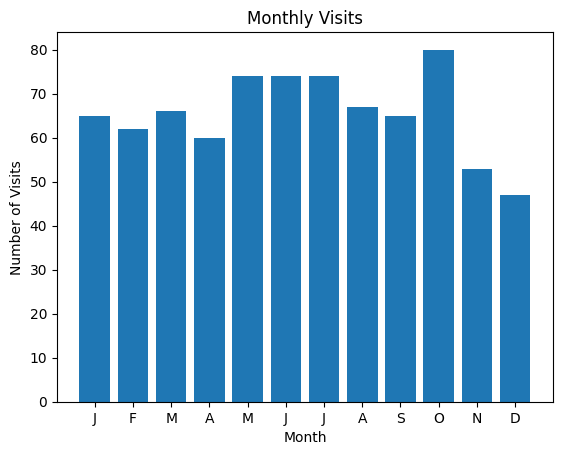

In [175]:
# this is the evaluation for the entire period of the dataset.
dateDataCleared["Month"] = dateDataCleared["date"].apply(lambda x: x.month)

monthly = dateDataCleared.groupby("Month").size().reset_index(name='Visits')
print(monthly)

# now, lets chart it:
plt.bar(monthly['Month'], monthly['Visits'])
plt.xlabel('Month')
plt.ylabel('Number of Visits')
plt.title('Monthly Visits')
plt.xticks(ticks=monthly['Month'], labels=['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
plt.show()



- add a new column "age group " to split the age to 5 categories:  40-49, 50-59, 60-69, and above 70)


In [155]:
patientInfoClearedBmi["age group"] = patientInfoClearedBmi["Age"].apply(lambda age: 
    "40-49" if age < 50 else 
    "50-59" if age < 60 else 
    "60-69" if age < 70 else 
    "70")
patientInfoClearedBmi

,Participant_ID,Sex,Age,Smoking_status,BMI,Disease,age group
0,1003300,Male,62,Previous,33.7597,2,60-69
1,1004025,Male,60,Previous,28.1173,1,60-69
2,1005551,Male,69,Previous,26.4159,2,60-69
3,1005594,Male,64,Previous,24.7550,1,60-69
4,1005624,Male,64,Previous,35.0773,2,60-69
...,...,...,...,...,...,...,...
2211,6009769,Male,48,Previous,39.3345,2,40-49
2212,6011693,Male,62,Previous,30.8813,2,60-69
2213,6015403,Female,60,Previous,34.7276,1,60-69
2214,6019982,Male,54,Never,25.3287,2,50-59


- Merge the two files to include the columns: Patient_ID, Sex, Age, BMI, Smoking_status, Number_of_visits, Disease and age group

In [172]:
dateDataMerge = dateDataCleared.groupby("Participant_ID").count().astype(int)
dateDataMerge
#merged = patientInfoClearedBmi.copy()
#merged["Visits"] = dateDataMerge["VisitDate"]["count"]
merged= patientInfoClearedBmi.join(dateDataMerge, on="Participant_ID")
merged.drop(columns=["Month", "date"], inplace=True)
merged.rename(columns={"VisitDate": "Number_of_visits", "Participant_ID": "Patient_ID"}, inplace=True)
merged["Number_of_visits"] = merged["Number_of_visits"].fillna(0)
merged["Number_of_visits"] = merged["Number_of_visits"].astype(int)
merged

,Patient_ID,Sex,Age,Smoking_status,BMI,Disease,age group,Number_of_visits
0,1003300,Male,62,Previous,33.7597,2,60-69,2
1,1004025,Male,60,Previous,28.1173,1,60-69,0
2,1005551,Male,69,Previous,26.4159,2,60-69,2
3,1005594,Male,64,Previous,24.7550,1,60-69,1
4,1005624,Male,64,Previous,35.0773,2,60-69,1
...,...,...,...,...,...,...,...,...
2211,6009769,Male,48,Previous,39.3345,2,40-49,0
2212,6011693,Male,62,Previous,30.8813,2,60-69,2
2213,6015403,Female,60,Previous,34.7276,1,60-69,0
2214,6019982,Male,54,Never,25.3287,2,50-59,0




# Task: Statistics (you don't need to check the model assumption in this exercise)

- Compare the BMI between the healthy and control groups using a box or violin plot.


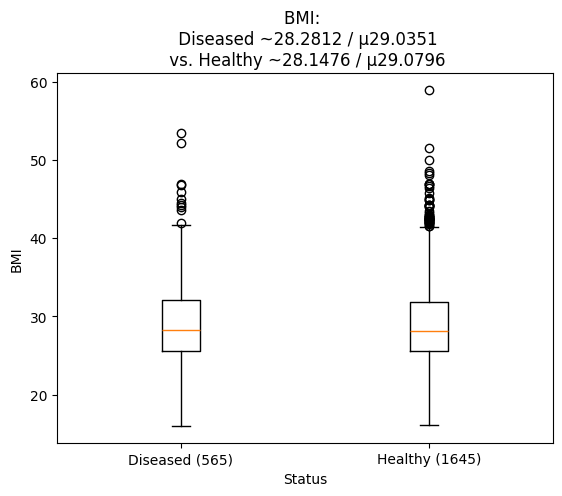

In [194]:
diseased_bmi = merged[merged['Disease'] == 1]['BMI']
healthy_bmi = merged[merged['Disease'] == 2]['BMI']
diseased_count = diseased_bmi.count()
healthy_count = healthy_bmi.count()
# Creating the boxplot
plt.boxplot([diseased_bmi, healthy_bmi], tick_labels=['Diseased (' + str(diseased_count) + ')', 'Healthy (' + str(healthy_count) + ')'])
plt.xlabel('Status')
plt.ylabel('BMI')
plt.title(f"BMI: \n Diseased ~{diseased_bmi.median():.4f} / μ{diseased_bmi.mean():.4f}\n vs. Healthy ~{healthy_bmi.median():.4f} / μ{healthy_bmi.mean():.4f}")
plt.show()


the BMI values are very similar for both groups of participants. the higher number of outliers can be explained by a significantly bigger participant count for the healthy ones.

- Examine if the proportion of smoking status differs between the healthy and control groups.


    Disease        Smoking_status  Count  proportion
0  Diseased               Current     92    0.162832
1  Diseased                 Never    214    0.378761
2  Diseased  Prefer not to answer      5    0.008850
3  Diseased              Previous    254    0.449558
4   Healthy               Current    258    0.156839
5   Healthy                 Never    635    0.386018
6   Healthy  Prefer not to answer      4    0.002432
7   Healthy              Previous    748    0.454711


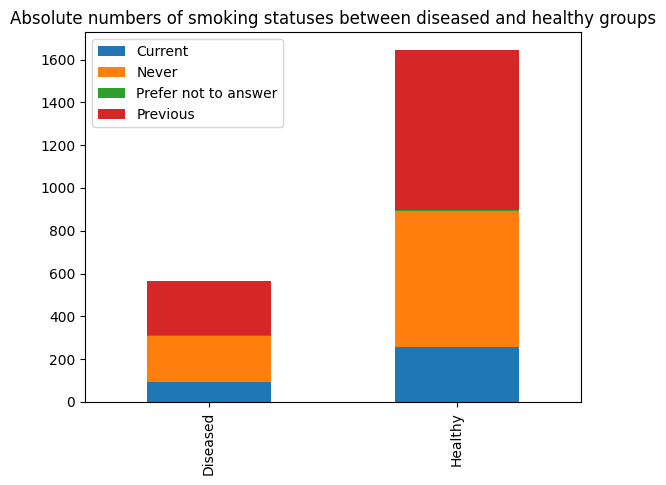

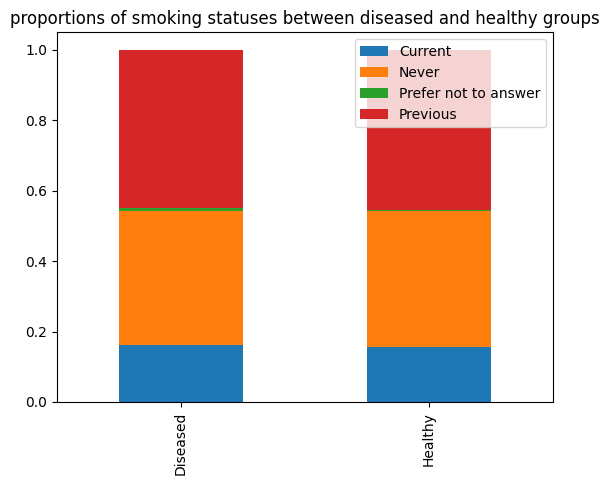

In [238]:
smokinginfo = merged.groupby(["Disease", "Smoking_status"])["Patient_ID"].count().reset_index().rename(columns={"Patient_ID": "Count"})
smokinginfo["proportion"] = smokinginfo.groupby("Disease")["Count"].transform(lambda x: x/x.sum())
smokinginfo["Disease"] = smokinginfo["Disease"].apply(lambda x: "Diseased" if x == 1 else "Healthy")
print(smokinginfo)

# smokinginfoGraph = pd.DataFrame({"Diseased": [123, 200, 1000, 354], "Healthy": [456, 111, 200, 684]})
# smokinginfoGraph.plot(kind='bar', stacked=True)
# plt.xlabel('Group')
# plt.ylabel('Proportion')
# plt.title('Proportion of Smoking Status between Diseased and Healthy Groups')
# plt.xticks([0, 1], ['Diseased', 'Healthy'])
# plt.legend(title='Smoking Status', bbox_to_anchor=(1.05, 1))
# plt.show()


dc = smokinginfo[(smokinginfo["Disease"]=="Diseased") & (smokinginfo["Smoking_status"]=="Current")]["Count"].values[0]
dn = smokinginfo[(smokinginfo["Disease"]=="Diseased") & (smokinginfo["Smoking_status"]=="Never")]["Count"].values[0]
dp = smokinginfo[(smokinginfo["Disease"]=="Diseased") & (smokinginfo["Smoking_status"]=="Prefer not to answer")]["Count"].values[0]
dprev = smokinginfo[(smokinginfo["Disease"]=="Diseased") & (smokinginfo["Smoking_status"]=="Previous")]["Count"].values[0]

hc = smokinginfo[(smokinginfo["Disease"]=="Healthy") & (smokinginfo["Smoking_status"]=="Current")]["Count"].values[0]
hn = smokinginfo[(smokinginfo["Disease"]=="Healthy") & (smokinginfo["Smoking_status"]=="Never")]["Count"].values[0]
hp = smokinginfo[(smokinginfo["Disease"]=="Healthy") & (smokinginfo["Smoking_status"]=="Prefer not to answer")]["Count"].values[0]
hprev = smokinginfo[(smokinginfo["Disease"]=="Healthy") & (smokinginfo["Smoking_status"]=="Previous")]["Count"].values[0]
# Assuming the DataFrame 'df' needs to be transposed to get two bars, each containing four parts
df = pd.DataFrame({
    'Diseased': [dc, dn, dp, dprev],  # Example values for Group1
    'Healthy': [hc, hn, hp, hprev]   # Example values for Group2
}, index=['Current', 'Never', 'Prefer not to answer', 'Previous'])  # Index represents the parts

# Transpose the DataFrame to get two bars (Group1 and Group2) each containing four parts (A, B, C, D)
df_transposed = df.T

# Plotting the transposed data in a stacked bar plot
df_transposed.plot(kind='bar', stacked=True)
plt.title('Absolute numbers of smoking statuses between diseased and healthy groups')

plt.show()

dc = smokinginfo[(smokinginfo["Disease"]=="Diseased") & (smokinginfo["Smoking_status"]=="Current")]["proportion"].values[0]
dn = smokinginfo[(smokinginfo["Disease"]=="Diseased") & (smokinginfo["Smoking_status"]=="Never")]["proportion"].values[0]
dp = smokinginfo[(smokinginfo["Disease"]=="Diseased") & (smokinginfo["Smoking_status"]=="Prefer not to answer")]["proportion"].values[0]
dprev = smokinginfo[(smokinginfo["Disease"]=="Diseased") & (smokinginfo["Smoking_status"]=="Previous")]["proportion"].values[0]

hc = smokinginfo[(smokinginfo["Disease"]=="Healthy") & (smokinginfo["Smoking_status"]=="Current")]["proportion"].values[0]
hn = smokinginfo[(smokinginfo["Disease"]=="Healthy") & (smokinginfo["Smoking_status"]=="Never")]["proportion"].values[0]
hp = smokinginfo[(smokinginfo["Disease"]=="Healthy") & (smokinginfo["Smoking_status"]=="Prefer not to answer")]["proportion"].values[0]
hprev = smokinginfo[(smokinginfo["Disease"]=="Healthy") & (smokinginfo["Smoking_status"]=="Previous")]["proportion"].values[0]
# Assuming the DataFrame 'df' needs to be transposed to get two bars, each containing four parts
df = pd.DataFrame({
    'Diseased': [dc, dn, dp, dprev],  # Example values for Group1
    'Healthy': [hc, hn, hp, hprev]   # Example values for Group2
}, index=['Current', 'Never', 'Prefer not to answer', 'Previous'])  # Index represents the parts

# Transpose the DataFrame to get two bars (Group1 and Group2) each containing four parts (A, B, C, D)
df_transposed = df.T

# Plotting the transposed data in a stacked bar plot
df_transposed.plot(kind='bar', stacked=True)
plt.title('proportions of smoking statuses between diseased and healthy groups')
plt.show()

when plotting the proportions of the different smoking statuses, it is obvious that there is no causal relationship between the desease and whether people smoke.

- Analyze the relationship between smoking status and the number of hospital visits, separately for the disease and healthy groups, and for the overall population.


In [246]:
def analyzeSmokingStatus(x, title):
    print(title)
    print([x.groupby("Smoking_status")["Number_of_visits"].sum(), 
           x.groupby("Smoking_status")["Number_of_visits"].sum() / x["Number_of_visits"].sum(),
           ])
# i split the dataset here, and run the same analysis on each part
analyzeSmokingStatus(merged, "Overall population")
analyzeSmokingStatus(merged[merged["Disease"] == 1], "Diseased")
analyzeSmokingStatus(merged[merged["Disease"] == 2], "Healthy")

overall population
[Smoking_status
Current                 117
Never                   314
Prefer not to answer      2
Previous                354
Name: Number_of_visits, dtype: int32, Smoking_status
Current                 0.148666
Never                   0.398983
Prefer not to answer    0.002541
Previous                0.449809
Name: Number_of_visits, dtype: float64]

Diseased
[Smoking_status
Current                 29
Never                   89
Prefer not to answer     1
Previous                82
Name: Number_of_visits, dtype: int32, Smoking_status
Current                 0.144279
Never                   0.442786
Prefer not to answer    0.004975
Previous                0.407960
Name: Number_of_visits, dtype: float64]

Healthy
[Smoking_status
Current                  88
Never                   225
Prefer not to answer      1
Previous                272
Name: Number_of_visits, dtype: int32, Smoking_status
Current                 0.150171
Never                   0.383959
Prefer not to

Smoking doesn't result in higher numbers of hospital visits when people are diseased. in contrast, both, previous and current smokers have a slightly higher percentage in healthy people in contrast 

- Determine if the number of visits is higher in the disease group compared to the healthy group.


In [243]:
print(merged.groupby("Disease")["Number_of_visits"].sum())
print(merged.groupby("Disease")["Patient_ID"].count())
# print(merged.groupby("Disease")["Number_of_visits"].sum() / merged.groupby("Disease")["Patient_ID"].count())
print(merged.groupby("Disease")["Number_of_visits"].mean())

Disease
1    201
2    586
Name: Number_of_visits, dtype: int32
Disease
1     565
2    1645
Name: Patient_ID, dtype: int64
Disease
1    0.355752
2    0.356231
Name: Number_of_visits, dtype: float64
The number of visits per patient is very slightly (0.1%) higher for healthy patients than for diseased patients.


The number of visits per patient is very slightly (0.1%) higher for healthy patients than for diseased patients.

- Calculate the disease prevalence (number of sick  / total number population) across different age groups  in our dataset, and test if the prevalence is different across the group


In [162]:
# we group the dataset into the different age groups, and then distinguish between sick and healthy patients.
print(merged.groupby(["age group", "Disease"])["Patient_ID"].count())
# we get the totals of the age groups
print(merged.groupby(["age group"])["Patient_ID"].count())
# we do the division
print(merged.groupby(["age group", "Disease"])["Patient_ID"].count() / merged.groupby(["age group"])["Patient_ID"].count())
# we then take a look at the numbers:

age group  Disease
40-49      1            42
           2           113
50-59      1           108
           2           389
60-69      1           407
           2          1116
70         1             8
           2            27
Name: Patient_ID, dtype: int64
age group
40-49     155
50-59     497
60-69    1523
70         35
Name: Patient_ID, dtype: int64
age group  Disease
40-49      1          0.270968
           2          0.729032
50-59      1          0.217304
           2          0.782696
60-69      1          0.267236
           2          0.732764
70         1          0.228571
           2          0.771429
Name: Patient_ID, dtype: float64


We can see that the prevalence varies between the age groups in a range of 72 to 78 percent.